# IAPR: Project ‒  Coin Counter


**Group ID:** 12

**Author 1 (sciper):** Vray Alexandre (310104)   
**Author 2 (sciper):** Aellen Edgar (311574)  
**Author 3 (sciper):** Robrdet Alexis (371391)   

**Release date:** 26.04.2024  
**Due date:** 29.05.2024 (11:59 pm)

In [2]:
import cv2
import os

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from utils.display import plot_images

data_folder = 'data/train'

## Read data

In [3]:
data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
6,L1010277,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0
10,L1010279,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0
15,L1010283,0,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0
8,L1010287,0,1,1,0,0,0,1,0,0,0,0,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
74,L1010517,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
80,L1010523,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1


In [4]:
def load_images_from_folder(folder):
    images = []
    for root, _, filenames in sorted(os.walk(folder)):
        for filename in sorted(filenames):
            img = cv2.imread(os.path.join(root, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

# Replace 'path_to_your_folder' with the path to the folder containing your images
x = load_images_from_folder(data_folder)
y = data.loc[:,'5CHF':].values

labels = data.loc[:,'5CHF':].columns

In [5]:
print(len(x))
print(x[0].shape)
print(y.shape)
print(y[0])
print(labels)

129
(4000, 6000, 3)
(81, 16)
[1 0 0 0 0 0 0 1 0 1 2 0 0 0 0 0]
Index(['5CHF', '2CHF', '1CHF', '0.5CHF', '0.2CHF', '0.1CHF', '0.05CHF', '2EUR',
       '1EUR', '0.5EUR', '0.2EUR', '0.1EUR', '0.05EUR', '0.02EUR', '0.01EUR',
       'OOD'],
      dtype='object')


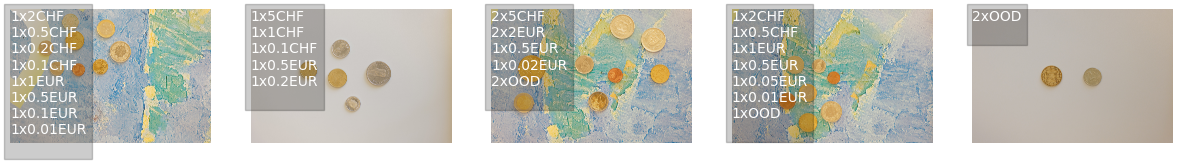

In [6]:
random.seed(42)
sample = random.sample(range(len(x)), k=5)

x_sample = [x[i] for i in sample]
y_sample = y[sample]
del x
del y

plot_images(images=x_sample, coins=y_sample, n_cols=5)

### Data augmentation

rotation, translation, scaling, cropping, changing brightness/contrast, adding noise

In [19]:
# Function to perform rotation
def rotate_image(image, angle):
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

# Function to perform translation
def translate_image(image, x, y):
    rows, cols, _ = image.shape
    translation_matrix = np.float32([[1, 0, x], [0, 1, y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

# Function to perform zooming
def zoom_image(image, scale_factor):
    # Calculate the center of the image
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 2
    # Calculate the zoomed region coordinates
    zoom_width = int(image.shape[1] * scale_factor)
    zoom_height = int(image.shape[0] * scale_factor)
    x1 = center_x - zoom_width // 2
    x2 = center_x + zoom_width // 2
    y1 = center_y - zoom_height // 2
    y2 = center_y + zoom_height // 2
    if scale_factor < 1:
        # Crop the zoomed region
        zoomed_region = image[y1:y2, x1:x2]
        resized_zoomed_region = cv2.resize(zoomed_region, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    else:
        # Padding
        resized_zoomed_region = np.zeros_like(image)
        resized_zoomed_region = cv2.resize(resized_zoomed_region, (zoom_width, zoom_height), interpolation=cv2.INTER_LINEAR)
        resized_zoomed_region[center_y-image.shape[0]//2:center_y+image.shape[0]//2,center_x-image.shape[1]//2:center_x+image.shape[1]//2] = image
        resized_zoomed_region = cv2.resize(resized_zoomed_region, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    return resized_zoomed_region

# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    # For each pixel, compute the new value g(i, j) = contrast * f(i, j) + brightness
    adjusted_image = cv2.addWeighted(image, contrast, np.zeros(image.shape, dtype=image.dtype), 0, brightness)
    return adjusted_image

# Function to add Gaussian noise
def add_noise(image, mean=0, std=15):
    noise = np.random.normal(mean, std, image.shape).astype('uint8')
    noisy_image = cv2.add(image, noise)
    return noisy_image

In [20]:
# Path to the directory containing the images
input_dir = "data/train/6. hand_outliers/"
output_dir = "data/train/augmented_images"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".JPG") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        # Read the image
        image = cv2.imread(image_path)
        cv2.imshow('image', image)
        
        # Perform augmentation
        augmented_images = []
        
        rotated_image = rotate_image(image, random.randint(-360, 360))
        augmented_images.append(rotated_image)
        
        translated_image = translate_image(image, random.randint(-20, 20), random.randint(-20, 20))
        augmented_images.append(translated_image)
        
        zoomed_image = zoom_image(image, random.uniform(0.8, 1.2))
        augmented_images.append(zoomed_image)
        
        brightness = random.randint(-5, 5)
        contrast = random.uniform(0.5, 1.5)
        brightness_contrast_image = adjust_brightness_contrast(image, brightness, contrast)
        augmented_images.append(brightness_contrast_image)
        
        noisy_image = add_noise(image)
        augmented_images.append(noisy_image)
        
        # Save augmented images
        for i, augmented_image in enumerate(augmented_images):
            output_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, augmented_image)

## 1. Localization

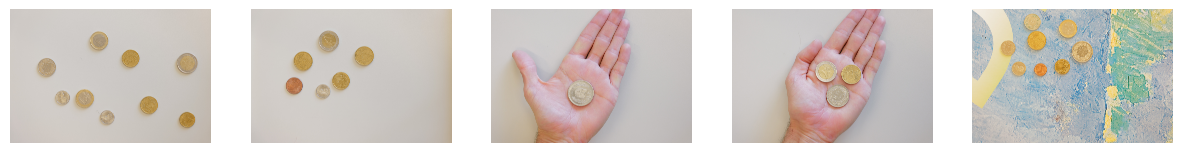

In [7]:
x_test = [x_sample[i] for i in [0,1,2,3,4]]
y_test = y_sample[[0,1,2,3,4]]

plot_images(images=x_test, n_cols=5)

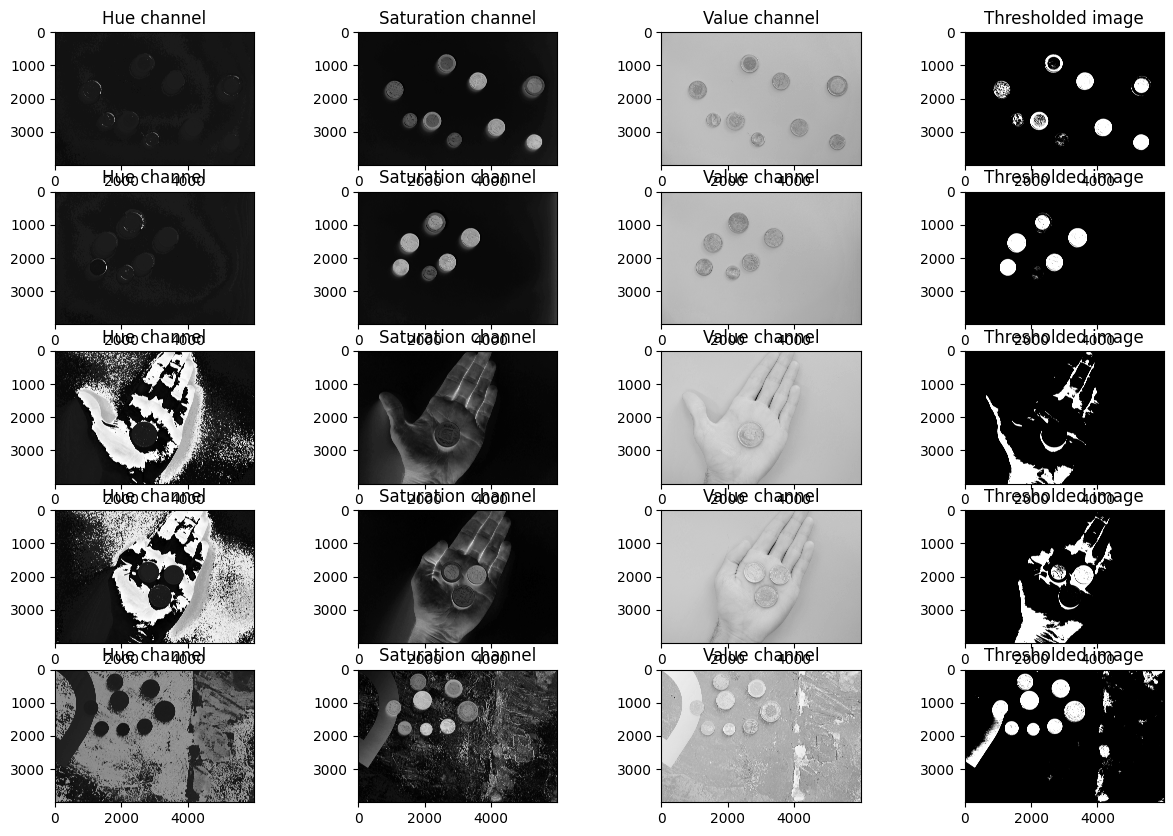

In [8]:
_, axs = plt.subplots(len(x_test), 4, figsize=(15,10))

for i in range(len(x_test)):
    hsv_img = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2HSV)
    hue = hsv_img[:,:,0]
    saturation = hsv_img[:,:,1]
    value = hsv_img[:,:,2]

    img_th = (hue<30)&(saturation>80)

    axs[i,0].imshow(hue, cmap='gray')
    axs[i,0].set_title('Hue channel')
    axs[i,1].imshow(saturation, cmap='gray')
    axs[i,1].set_title('Saturation channel')
    axs[i,2].imshow(value, cmap='gray')
    axs[i,2].set_title('Value channel')
    axs[i,3].imshow(img_th, cmap='gray')
    axs[i,3].set_title('Thresholded image')


## 2. Feature extraction

## 3. Classification